In [1]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from tqdm import tqdm
import pandas as pd
import pickle as pkl
import notebook_helper
import sys
import numpy as np
import imodelsx
import imodelsx.process_results
import mprompt.data.data
from mprompt.data.data import TASKS_D3
import mprompt.methods.m4_evaluate as m4_evaluate
tqdm.pandas()
TASK_NAMES = list(TASKS_D3.keys())
sys.path.append('../experiments/')
# results_dir = '/home/chansingh/mntv1/mprompt/feb18_synthetic_sweep'
results_dir = '/home/chansingh/mntv1/mprompt/feb25'

In [2]:
r = imodelsx.process_results.get_results_df(results_dir, use_cached=False)
r = imodelsx.process_results.fill_missing_args_with_default(r, experiment_filename='01_explain.py')

100%|██████████| 85/85 [00:07<00:00, 10.99it/s]


In [4]:
# metadata
r['task_str'] = r.apply(lambda row: mprompt.data.data.get_task_str(row['module_name'], row['module_num']), axis=1)
r['task_keyword'] = r['task_str'].apply(lambda task_str: mprompt.data.data.get_groundtruth_keyword(task_str))
r['task_name (groundtruth)'] = r['task_str'].apply(lambda s: s.split('_')[-1])
r['ngrams_restricted'] = ~(r['module_num_restrict'] == -1)
r['num_generated_explanations'] = r['explanation_init_strs'].apply(lambda x: len(x))

# recompute recovery metrics
r['score_contains_keywords'] = r.apply(lambda row: m4_evaluate.compute_score_contains_keywords(row, row['explanation_init_strs']), axis=1)
# r['score_bert'] = r.progress_apply(lambda row: m4_evaluate.compute_score_bert(row, row['explanation_init_strs']), axis=1)

# metrics
# for met_suff in ['contains_keywords']:
for met_suff in ['contains_keywords', 'bert']:
    if 'score_' + met_suff in r.columns:
        met_val = r['score_' + met_suff]
        r['top_' + met_suff] = met_val.apply(lambda x: x[0])
        r['any_' + met_suff] = met_val.apply(lambda x: np.max(x))
        r['mean_' + met_suff] = met_val.apply(lambda x: np.mean(x))
        r[f'mean_{met_suff}_weighted'] = r[f'mean_{met_suff}'] * r['num_generated_explanations']
r['row_count_helper'] = 1

# simplifying
r = r.sort_values(by='top_score_synthetic', ascending=False).round(3)
default_params = {
    'noise_ngram_scores': 0,
    'module_num_restrict': -1,
}
rd = r
for k, v in default_params.items():
    rd = rd[rd[k] == v]

In [8]:
sorted([i for i in range(54) if not i in rd.module_num.unique()])

[24, 25, 47, 48, 49, 51]

# Top results

In [4]:
with pd.option_context('display.max_colwidth', -1, 'display.max_rows', 200):
    d = (
        rd[[
            'task_keyword', 'top_explanation_init_strs',
            'top_contains_keywords', #        'mean_contains_keywords',
            'top_score_synthetic', 'module_num'
        ]]
        .rename(columns={
            'task_keyword': 'GT Explanation',
            'top_explanation_init_strs': 'Generated Explanation',
        })
    )
    d_ = d[d.top_contains_keywords == 0]
    slice_ = pd.IndexSlice[d_.index, d_.columns]

    # s = d.style
    display(
        d
        .style.hide()
        .set_properties(**{'background-color': '#132639'}, subset=slice_)
        .format(precision=2)
   )

GT Explanation,Generated Explanation,top_contains_keywords,top_score_synthetic,module_num
Hillary,name hillary or hillary clinton,True,0.53,17
evacuation,"concept of evacuation, or the process of leaving a place in an emergency situation",True,0.47,5
abortion,topic of abortion,True,0.40,21
pro-life,discussion of abortion and the related topics of pro-life and pro-choice,True,0.40,20
politics,politics,True,0.35,53
physics,physics,True,0.33,22
Hillary,hillary or hillary clinton,True,0.32,16
atheistic,"atheism and related topics, such as theism, religious beliefs, and atheists",True,0.30,4
utility,letter u or the word utilization or utility,True,0.30,15
toxic,idea of danger and toxicity,True,0.29,19


### Explanation recovery accuracy results

In [7]:
r = r[r['module_num'] < 40]

In [8]:
groupings = ['noise_ngram_scores', 'ngrams_restricted']
metrics = ['any_contains_keywords', 'top_contains_keywords', 'mean_contains_keywords']
metrics_weighted = ['mean_contains_keywords_weighted']
if 'score_bert' in r.columns:
    metrics += ['any_bert', 'top_bert', 'mean_bert']
    metrics_weighted += ['mean_bert_weighted']
helpers = ['row_count_helper', 'num_generated_explanations']
index_remap = {
    (0.0, False): 'Default',
    (0.0,  True): '+Ngram restriction',
    (3.0, False): '+Module noise',
}

g = (
    r
    .filter(groupings + metrics + metrics_weighted + helpers)
    .groupby(groupings)
    .sum()
    .sort_values(by='any_contains_keywords', ascending=False)
)
for met in metrics:
    g[met] = g[met] / g['row_count_helper']
for met in metrics_weighted:
    g[met] = g[met] / g['num_generated_explanations']
g = (
    g
    .drop(columns=helpers + [k for k in ['mean_contains_keywords', 'mean_bert', 'any_bert', 'any_contains_keywords'] if k in g.columns])
    .rename(
        columns={
            'any_contains_keywords': 'Accuracy (top-5)',
            'top_contains_keywords': 'Accuracy',
            'mean_contains_keywords_weighted': 'Accuracy (w/out synthetic ranking)',
            'mean_contains_keywords': 'Accuracy (w/out synthetic, unweighted)',
            'top_bert': 'BERTScore',
            'mean_bert_weighted': 'BERTScore (w/out synthetic ranking)',
        }
)).round(2)

g.index = [index_remap[x] for x in g.index.values]
display(g)

,Accuracy,Accuracy (w/out synthetic ranking)
Default,0.84,0.73
+Module noise,0.67,0.45
+Ngram restriction,0.77,0.67


### Does synthetic score help explanation recovery?

In [42]:
groupings = ['noise_ngram_scores', 'ngrams_restricted', 'top_contains_keywords']
metrics = ['top_score_synthetic']
g2 = (
    r
    .filter(groupings + metrics)
    .groupby(groupings)
    .mean()
    .round(3)
    .pivot_table(index=['noise_ngram_scores', 'ngrams_restricted'],
                 columns='top_contains_keywords',
                 values='top_score_synthetic')
    .rename_axis(None, axis=1)  
    .rename(columns={
    True: 'Synthetic score (correct)',
    False: 'Synthetic score (incorrect)',
    })
)
g2.index = [index_remap[x] for x in g2.index.values]
display(g2)

,Synthetic score (incorrect),Synthetic score (correct)
Default,0.140,0.273
+Ngram restriction,0.110,0.222
+Module noise,0.082,0.268


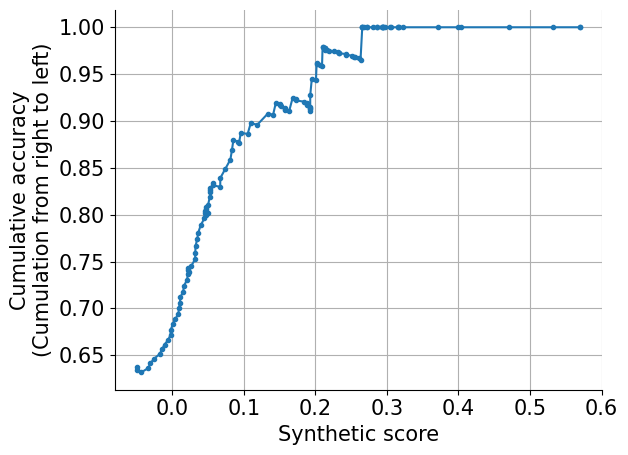

In [43]:
# compute corrects
scores_synth = sum(r.score_synthetic.values, [])
corrects = sum(r.score_contains_keywords.values, [])
args = np.argsort(scores_synth)[::-1] # high to low
scores_synth = np.array(scores_synth)[args]
corrects = np.array(corrects)[args]

# plot
plt.plot(scores_synth, np.cumsum(corrects) / np.arange(1, len(corrects) + 1), '.-')
plt.ylabel('Cumulative accuracy\n(Cumulation from right to left)')
plt.xlabel('Synthetic score')
plt.grid()
plt.show()

# Details

In [ ]:
# display full strings
with pd.option_context('display.max_colwidth', -1, 'display.max_rows', 200):
    display(
        rd
        .filter(['task_keyword', 'top_explanation_init_strs', 'top_contains_keywords', 'top_score_synthetic', 'module_num'])
        # .filter(['top_score_contains_keywords', 'top_score_synthetic', 'top_explanation_init_strs', 'explanation_init_ngrams', 'module_num'])
        # .filter(['top_explanation_init_strs', 'explanation_init_ngrams', 'top_strs_added'])
        # .filter(['explanation_init_strs', 'explanation_init_ngrams',])
        # .head(n=20)
    )